# Into

This work focuses on classifying toxic comments from [this](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge) dataset.

It is a multilabel problem, but I guess the main thing is separating the toxic comments in general from the non-toxic ones, so in a sense we can think of it as a binary classification problem.

In [1]:
# Using drive to get the kaggle API key and save models for persistance

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
import shutil

try:
    os.mkdir("/root/.kaggle")
except:
    pass

shutil.copy("/content/drive/MyDrive/Kaggle/kaggle.json", "/root/.kaggle/kaggle.json")

'/root/.kaggle/kaggle.json'

In [3]:
%%capture
! pip install pytorch-lightning
! pip install kaggle
! pip install transformers
! kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
! unzip /content/jigsaw-toxic-comment-classification-challenge.zip
! unzip test_labels.csv.zip
! unzip test.csv.zip
! unzip train.csv.zip

In [4]:
from typing import Dict, Tuple
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import average_precision_score, precision_recall_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import DistilBertForSequenceClassification, DistilBertConfig
from transformers import DistilBertTokenizer

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

import torchmetrics
from torchmetrics.functional import f1_score, auroc, average_precision
from torchmetrics.functional import roc, precision_recall_curve
from torchmetrics.functional import recall, precision, specificity, accuracy

# EDA

Let's load the data

In [5]:
train = pd.read_csv("train.csv")

In [6]:
train.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


Main data in the train table are the comment text and six classes for the toxic text.

In [7]:
test = pd.read_csv("test.csv")

In [8]:
test.head(2)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...


The test data only has the comment text, but labels for some of the test comments are available, so I will add them and then merge the train and test datasets.

In [9]:
test_labels = pd.read_csv("test_labels.csv")
good_test_labels = test_labels.loc[test_labels.iloc[:, 1:6].sum(axis=1) > -1]

In [10]:
test = test.merge(good_test_labels, on="id", how="inner")

In [11]:
labels = train.columns[2:]

In [12]:
test.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0


In [13]:
data = pd.concat([train, test])
data = data.reset_index().drop(["index", "id"], axis=1)
data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [14]:
data.shape

(223549, 7)

After merging the train and test datasets were are left with ~220k exmaples

In [15]:
data["label"] = data[labels].any(axis=1)

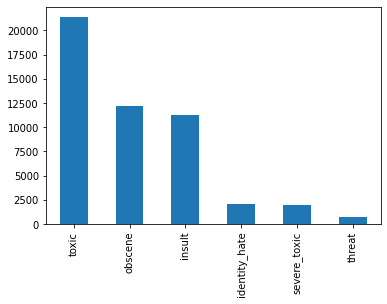

In [16]:
data[labels].sum().sort_values(ascending=False).plot(kind="bar")
plt.show()

Most positive examples in the data are either toxic, obscene or an insult.

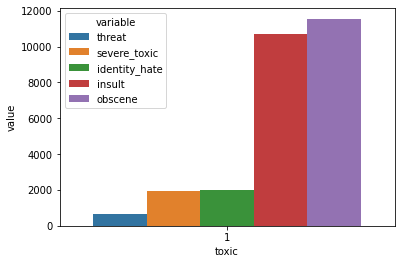

In [17]:
a = (
    data.groupby("toxic")
    .sum()
    .loc[[1]]
    .reset_index()
    .melt("toxic")
    .drop(5)
    .sort_values("value")
)
sns.barplot(y=a.value, x=a.toxic, hue=a.variable)
plt.show()

This is a multilabel problem so each positive class can have a couple of labels, in the case of toxic comments they are alse usually obscene and an insult.

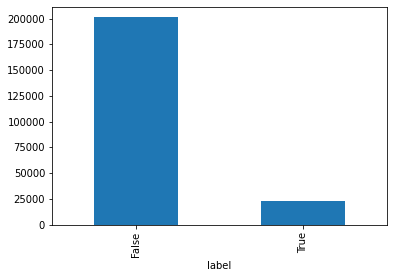

In [18]:
data.groupby("label")["label"].count().plot(kind="bar")
plt.show()

In [19]:
print(f"Percentage of positive labels: {data.label.sum() / data.shape[0]:.2%}")

Percentage of positive labels: 10.05%


The data is also very unbalanced, only 10% of the data have at least one label.

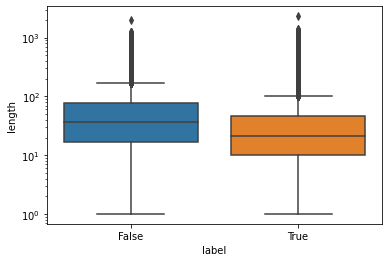

In [20]:
data["length"] = data.comment_text.str.split().str.len()
sns.boxplot(data=data, y="length", x="label")
plt.yscale("log")
plt.show()

In [21]:
data.groupby("label")["length"].describe().T

label,False,True
count,201081.000000,22468.000000
mean,68.399645,49.669619
std,98.598380,105.514257
min,1.000000,1.000000
25%,17.000000,10.000000
50%,37.000000,21.000000
75%,77.000000,46.000000
max,1990.000000,2321.000000


Most comments have less than 128 words, with toxic comments being even shorter.

In [79]:
count_vect = CountVectorizer(strip_accents="unicode", stop_words="english")

In [80]:
count_trans = count_vect.fit_transform(data.comment_text)
count_names = count_vect.get_feature_names_out()
count_sum = count_trans.sum(axis=0)

In [81]:
word_counts = pd.DataFrame(
    {"word": count_names.tolist(), "count": count_sum.tolist()[0]}
)
word_counts.sort_values("count", ascending=False).describe()

,count
count,1.496004e+07
mean,1.828054e+00
std,5.563613e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,7.995900e+04


In [82]:
word_counts.sort_values("count", ascending=False).head(10)

,word,count
1112839,article,79959
14335532,wikipedia,63360
9209081,page,61204
12727223,talk,44512
7449056,like,38549
6928714,just,38372
4044032,don,32158
13026647,think,28154
7103867,know,25837
9462508,people,25329


Most common words are about wikipedia which is logical as the dataset is gatheres from it.

# DATA PREP


In [23]:
# joblib.dump(data, "/content/drive/MyDrive/comments_data.dump")
data = joblib.load("/content/drive/MyDrive/comments_data.dump")

In [24]:
data.head(2)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label,length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,False,43
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,False,17


In [25]:
class CommentData:
    def __init__(self, comments: pd.Series, labels: pd.DataFrame):
        assert isinstance(comments, pd.Series), "Comments must be a pd.Series"
        assert isinstance(labels, pd.DataFrame), "Labels must be a pd.DataFrame"

        self.comments = comments
        self.labels = labels
        self.encoder = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, ix: int) -> Tuple[Dict[str, torch.tensor], torch.tensor]:
        "Return encoded text and labels for given data ix"
        enc_text = self.encoder(
            self.comments.iloc[ix],
            max_length=128,  # max 128 length encoding as most comments are short
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        enc_text = {k: v.squeeze(dim=0) for k, v in enc_text.items()}
        label = torch.tensor(self.labels.iloc[ix].to_list())
        return enc_text, label

In [26]:
train_data, test_data = train_test_split(
    data, stratify=data.label, test_size=0.1, random_state=42
)
train_data, eval_data = train_test_split(
    train_data, stratify=train_data.label, test_size=0.12, random_state=42
)

In [27]:
print(train_data.shape)
print(eval_data.shape)
print(test_data.shape)

(177050, 9)
(24144, 9)
(22355, 9)


There is quite a lot of data so most of it I will leave for training, feel like 20k values should be enough for testing and validation.

In [28]:
BATCH_SIZE = 1500  # Seems like high batch numbers for NLP are more efficient

train_set = CommentData(train_data.comment_text, train_data[labels])
eval_set = CommentData(eval_data.comment_text, eval_data[labels])
test_set = CommentData(test_data.comment_text, test_data[labels])

train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4
)
eval_loader = DataLoader(
    eval_set, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4
)
test_loader = DataLoader(
    test_set, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4
)

# Simple binary model

In [ ]:
base_data = pd.concat([train_data, eval_data])

Will combine eval and train sets for the simple baseline models

In [96]:
bad_vect = CountVectorizer(
    strip_accents="unicode", stop_words="english", max_features=100
)
bad_vect.fit(base_data[base_data.label].comment_text)
bad_words = bad_vect.get_feature_names_out()

In [97]:
bad_words

array(['admin', 'aids', 'anal', 'article', 'ass', 'asshole', 'bad',
       'balls', 'bark', 'bastard', 'big', 'bitch', 'block', 'blocked',
       'boob', 'bullshit', 'care', 'cock', 'come', 'cunt', 'damn', 'dick',
       'dicks', 'did', 'die', 'does', 'don', 'dont', 'eat', 'edit',
       'edits', 'fag', 'faggot', 'faggots', 'fat', 'freedom', 'fuck',
       'fucker', 'fucking', 'gay', 'god', 'going', 'good', 'hate', 'hell',
       'hey', 'hi', 'idiot', 'jew', 'just', 'kill', 'know', 'life',
       'like', 'little', 'll', 'look', 'loser', 'love', 'make', 'man',
       'moron', 'mother', 'need', 'nigger', 'niggers', 'nipple', 'oh',
       'page', 'penis', 'people', 'person', 'piece', 'pig', 'poop',
       'really', 'right', 'rules', 'said', 'say', 'sex', 'shit', 'shut',
       'stop', 'stupid', 'suck', 'sucks', 'talk', 'tell', 'think', 'time',
       'user', 'vandalism', 've', 'wanker', 'want', 'way', 'wiki',
       'wikipedia', 'youfuck'], dtype=object)

In [98]:
bad_words = [
    "aids",
    "anal",
    "ass",
    "asshole",
    "bad",
    "balls",
    "bark",
    "bastard",
    "big",
    "bitch",
    "block",
    "blocked",
    "boob",
    "bullshit",
    "cock",
    "cunt",
    "damn",
    "dick",
    "dicks",
    "die",
    "eat",
    "fag",
    "faggot",
    "faggots",
    "fat",
    "fuck",
    "fucker",
    "fucking",
    "gay",
    "hate",
    "hell",
    "idiot",
    "jew",
    "kill",
    "loser",
    "moron",
    "mother",
    "need",
    "nigger",
    "niggers",
    "nipple",
    "penis",
    "piece",
    "pig",
    "poop",
    "sex",
    "shit",
    "shut",
    "stop",
    "stupid",
    "suck",
    "sucks",
    "vandalism",
    "wanker",
    "youfuck",
]

Manualy remove some common words that can definetely be in both toxic and not toxic reviews like `article`

In [99]:
bin_preds = []
for comment in test_data.comment_text:
    if any(word.lower() in bad_words for word in comment.split()):
        bin_preds.append(1)
    else:
        bin_preds.append(0)

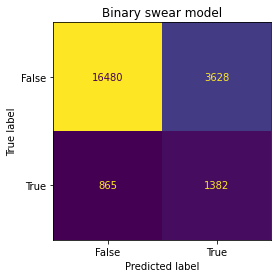

In [100]:
ConfusionMatrixDisplay.from_predictions(test_data.label, bin_preds, colorbar=False)
plt.title("Binary swear model")
plt.show()

In [102]:
print(classification_report(test_data.label, bin_preds))

              precision    recall  f1-score   support

       False       0.95      0.82      0.88     20108
        True       0.28      0.62      0.38      2247

    accuracy                           0.80     22355
   macro avg       0.61      0.72      0.63     22355
weighted avg       0.88      0.80      0.83     22355



This model gets a lot of fase positives and doesn't have great recall, the preformance could probably be improved by adding more swear words and refining the `bad_words` list in general, but let's move on to more powerful models.

# Baseline model wiht logistic regression

In [ ]:
base_models = {}

for label in labels.tolist():
    vectorizer = TfidfVectorizer(
        strip_accents="unicode", stop_words="english", ngram_range=(1, 2), min_df=3
    )
    log_reg = LogisticRegressionCV(cv=3, max_iter=50, n_jobs=-1)
    base_model = Pipeline([("vectorizer", vectorizer), ("cls", log_reg)])
    base_model.fit(base_data.comment_text, base_data[label])
    base_models[label] = base_model

In [ ]:
# joblib.dump(base_models, "/content/drive/MyDrive/base_models.dump")
base_models = joblib.load("/content/drive/MyDrive/base_models.dump")

In [55]:
pred_probas = []
for model in base_models.values():
    pred_probas.append(model.predict_proba(test_data.comment_text))

In [56]:
probas = [i[:, 1] for i in pred_probas]
preds = [(i > 0.5).astype(int) for i in probas]
preds = pd.DataFrame(np.array(preds).T, columns=labels)
preds["label"] = preds.any(axis=1)

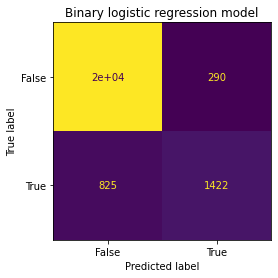

In [74]:
ConfusionMatrixDisplay.from_predictions(test_data.label, preds.label, colorbar=False)
plt.title("Binary logistic regression model")
plt.show()

In [58]:
print(classification_report(test_data.label, preds.label))
print(classification_report(test_data[labels], preds[labels], target_names=labels))

              precision    recall  f1-score   support

       False       0.96      0.99      0.97     20108
        True       0.83      0.63      0.72      2247

    accuracy                           0.95     22355
   macro avg       0.90      0.81      0.85     22355
weighted avg       0.95      0.95      0.95     22355

               precision    recall  f1-score   support

        toxic       0.82      0.64      0.72      2134
 severe_toxic       0.52      0.22      0.31       194
      obscene       0.83      0.65      0.73      1193
       threat       0.53      0.29      0.37        63
       insult       0.81      0.53      0.64      1133
identity_hate       0.67      0.35      0.46       209

    micro avg       0.81      0.59      0.68      4926
    macro avg       0.70      0.45      0.54      4926
 weighted avg       0.80      0.59      0.67      4926
  samples avg       0.06      0.05      0.05      4926



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The logistic regression baseline has good precision but it's recall ir pretty bad.

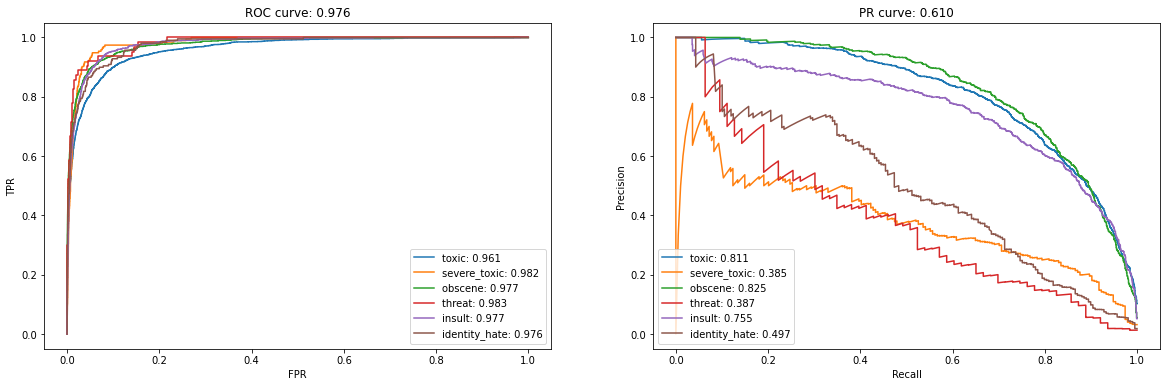

In [59]:
fig, ax = plt.subplots(1, 2, figsize=[20, 6])
ax = ax.flatten()

y = test_data[labels]

for i, label in enumerate(labels):
    score = roc_auc_score(y.iloc[:, i], probas[i])
    fpr, tpr, thresh = roc_curve(y.iloc[:, i], probas[i])
    ax[0].plot(fpr, tpr, label=f"{label}: {score:.3f}")
    ax[0].set_xlabel("FPR")
    ax[0].set_ylabel("TPR")
    ax[0].legend()
avg_score = roc_auc_score(y, np.array(probas).T, average="macro")
ax[0].set_title(f"ROC curve: {avg_score:.3f}")

for i, label in enumerate(labels):
    score = average_precision_score(y.iloc[:, i], probas[i])
    precision, recall, thresh = precision_recall_curve(y.iloc[:, i], probas[i])
    ax[1].plot(recall, precision, label=f"{label}: {score:.3f}")
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].legend()
avg_score = average_precision_score(y, np.array(probas).T, average="macro")
ax[1].set_title(f"PR curve: {avg_score:.3f}")

plt.show()

In [83]:
all_model_feats = []
for label, model in base_models.items():
    coefs = model["cls"].coef_
    feat_names = model["vectorizer"].get_feature_names_out()
    neg_feats = (
        pd.DataFrame(
            list(zip(feat_names, coefs[0])), columns=[f"{label}_feat", f"{label}_coef"]
        )
        .sort_values(f"{label}_coef", ascending=False)
        .tail(10)
    )
    pos_feats = (
        pd.DataFrame(
            list(zip(feat_names, coefs[0])), columns=[f"{label}_feat", f"{label}_coef"]
        )
        .sort_values(f"{label}_coef", ascending=False)
        .head(10)
    )
    comb = pos_feats.append(neg_feats).reset_index().drop("index", axis=1)
    all_model_feats.append(comb)

In [84]:
pd.concat(all_model_feats, axis=1)

,toxic_feat,toxic_coef,severe_toxic_feat,severe_toxic_coef,obscene_feat,obscene_coef,threat_feat,threat_coef,insult_feat,insult_coef,identity_hate_feat,identity_hate_coef
0,fuck,27.993489,fucking,7.787643,fuck,32.923835,kill,13.095482,idiot,17.368700,nigger,17.302334
1,idiot,25.238995,fuck,6.958777,fucking,28.495415,death,9.985648,bitch,13.360658,nigga,16.239463
2,fucking,23.468756,motherfucker,5.745593,bitch,23.840754,die,9.721781,stupid,13.227852,niggers,15.052263
3,stupid,22.652170,fucker,5.543776,asshole,21.697156,burn,9.073227,idiots,12.994861,niggaz,11.776592
4,shit,20.577312,dick,5.540064,shit,21.254807,rape,8.730331,asshole,12.569546,faggots,11.308098
5,asshole,18.960795,bitch,5.514811,fucked,19.361990,stab,8.441385,fucking,11.116467,niggas,10.995644
6,idiots,18.879295,shit,5.245238,bullshit,19.205100,cut,8.426632,moron,10.251699,gay,10.778149
7,bitch,18.875114,fuckin,5.122369,ass,18.107773,punch,8.300784,faggot,10.218115,homosexuals,10.501487
8,ass,18.310675,cocksucker,5.116734,fucker,16.754775,hang,8.141625,fuck,9.709347,homos,10.385717
9,bullshit,17.094817,ass,4.921016,motherfucker,16.528911,murdered,8.065257,bastard,9.627125,jew,10.117453


Interestingly both positive and negative coeficient features have swear words.

# distilBERT model

Now moving on to deep learning models

For modeling I will make **3** models:  
* DistilBERT model on all of the data
* DistilBERT model on downsampled data
* DistilBERT model with weights in the loss funcion 

In [ ]:
class CommentClassifier(pl.LightningModule):
    def __init__(
        self,
        model: nn.Module,
        pos_weight: torch.tensor,
        lr: float = 5e-4,
        threshold: float = 0.5,
    ):
        super().__init__()
        self.model = model
        self.lr = lr
        self.threshold = threshold
        self.pos_weight = pos_weight
        self.train_f1_score = torchmetrics.F1Score(average="macro", num_classes=6)
        self.eval_f1_score = torchmetrics.F1Score(average="macro", num_classes=6)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            [p for p in self.parameters() if p.requires_grad], lr=self.lr
        )
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=1e-3, total_steps=self.trainer.estimated_stepping_batches
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "interval": "step"},
        }

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)

    def training_step(self, batch: torch.tensor, batch_idx: int):
        loss, logits, y = self._step(batch)
        y_hat = torch.sigmoid(logits)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.train_f1_score(y_hat, y)
        self.log("train_f1_score", self.train_f1_score, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch: torch.tensor, batch_idx: int):
        loss, logits, y = self._step(batch)
        y_hat = torch.sigmoid(logits)
        self.log("eval_loss", loss, on_step=False, on_epoch=True)
        self.eval_f1_score(y_hat, y)
        self.log("eval_f1_score", self.eval_f1_score, on_step=False, on_epoch=True)
        return loss

    def predict_step(self, batch: torch.tensor, batch_idx: int):
        x, y = batch
        logits = self(**x).logits
        y_hat = (torch.sigmoid(logits) > self.threshold).int()
        return y, y_hat, logits

    def _step(self, batch: torch.tensor):
        x, y = batch
        logits = self(**x).logits
        loss = F.binary_cross_entropy_with_logits(
            logits, y.float(), pos_weight=self.pos_weight
        )
        return loss, logits, y

In [ ]:
# Load the distilBERT architecture
bert = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=len(labels)
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

In [ ]:
def config_model(model: pl.LightningModule, grad: bool = False, *args, **kwargs):
    "Create Pytorch Lightning model with given params"
    base = DistilBertForSequenceClassification.from_pretrained(
        "distilbert-base-uncased", num_labels=len(labels)
    )
    for param in base.distilbert.parameters():
        param.requires_grad = grad
    cls = model(base, *args, **kwargs)
    return cls

In [ ]:
comment_classifier = config_model(
    CommentClassifier, pos_weight=torch.ones(len(labels)).cuda()
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

In [ ]:
EPOCHS = 40

checkpoint_callback = ModelCheckpoint(
    save_top_k=5,
    save_last=True,
    monitor="eval_f1_score",
    mode="max",
    save_weights_only=True,
    dirpath="/content/drive/MyDrive/comments",
    filename="no-weights-{epoch:02d}-{eval_f1_score:.2f}",
)
logger = pl.loggers.csv_logs.CSVLogger("/content/drive/MyDrive/comments")
trainer = pl.Trainer(
    default_root_dir="/content/drive/MyDrive/comments",
    max_epochs=EPOCHS,
    logger=logger,
    log_every_n_steps=50,
    accelerator="gpu",
    devices=-1,
    callbacks=[checkpoint_callback],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# trainer.fit(model=comment_classifier, train_dataloaders=train_loader, val_dataloaders=eval_loader)

# distilBERT with down-sampled train data

Dowsampling negative labels by half to bring positives closer to 20%.

In [ ]:
sampled_train_data = (
    train_data.loc[train_data.label == False].copy().sample(frac=0.5, random_state=42)
)
sampled_train_data = pd.concat(
    [sampled_train_data, train_data.loc[train_data.label].copy()]
)

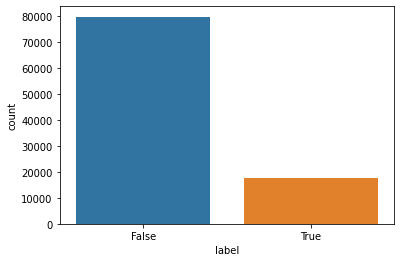

In [ ]:
sns.countplot(x=sampled_train_data.label);

In [ ]:
print(
    f"Percentage of positives in down-sampled data: {sampled_train_data.label.sum() / (len(sampled_train_data)):.2%}"
)

Percentage of positives in down-sampled data: 18.26%


In [ ]:
comment_classifier_sampled = config_model(
    CommentClassifier, pos_weight=torch.ones(len(labels)).cuda()
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

In [ ]:
BATCH_SIZE = 1500

sampled_train_set = CommentData(
    sampled_train_data.comment_text, sampled_train_data[labels]
)
train_loader = DataLoader(
    sampled_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
)

In [ ]:
EPOCHS = 40

checkpoint_callback = ModelCheckpoint(
    save_top_k=10,
    save_last=True,
    monitor="eval_f1_score",
    mode="max",
    save_weights_only=True,
    dirpath="/content/drive/MyDrive/comments",
    filename="sampled2-{epoch:02d}-{eval_f1_score:.2f}",
)
logger = pl.loggers.csv_logs.CSVLogger("/content/drive/MyDrive/comments")
trainer = pl.Trainer(
    default_root_dir="/content/drive/MyDrive/comments",
    max_epochs=EPOCHS,
    logger=logger,
    log_every_n_steps=50,
    accelerator="gpu",
    devices=-1,
    callbacks=[checkpoint_callback],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# trainer.fit(model=comment_classifier_sampled, train_dataloaders=train_loader, val_dataloaders=eval_loader)

# distilBERT with weights

Adding weights for each example in a binary sense, so only two weights: either toxic or not.
Will change the dataset and model a bit to use the example wieghts.

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

train_weights = torch.tensor(
    compute_sample_weight(class_weight="balanced", y=train_data.label)
)
eval_weights = torch.tensor(
    compute_sample_weight(class_weight="balanced", y=eval_data.label)
)

In [ ]:
class CommentDataW:
    def __init__(
        self, comments: pd.Series, labels: pd.DataFrame, weights: torch.tensor
    ):
        assert isinstance(comments, pd.Series), "Comments must be a pd.Series"
        assert isinstance(labels, pd.DataFrame), "Labels must be a pd.DataFrame"

        self.comments = comments
        self.labels = labels
        self.weights = weights
        self.encoder = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

    def __len__(self):
        return len(self.comments)

    def __getitem__(
        self, ix: int
    ) -> Tuple[Dict[str, torch.tensor], torch.tensor, torch.tensor]:
        "Return encoded text and labels for given data ix"
        enc_text = self.encoder(
            self.comments.iloc[ix],
            max_length=128,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        enc_text = {k: v.squeeze(dim=0) for k, v in enc_text.items()}
        label = torch.tensor(self.labels.iloc[ix].to_list())
        weight = self.weights[ix].repeat(self.labels.shape[1])
        return enc_text, label, weight

In [ ]:
BATCH_SIZE = 1500

train_set = CommentDataW(train_data.comment_text, train_data[labels], train_weights)
eval_set = CommentDataW(eval_data.comment_text, eval_data[labels], eval_weights)

train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4
)
eval_loader = DataLoader(
    eval_set, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4
)

In [ ]:
class CommentClassifierW(CommentClassifier):
    def _step(self, batch: torch.tensor):
        x, y, weight = batch
        logits = self(**x).logits
        loss = F.binary_cross_entropy_with_logits(logits, y.float(), weight=weight)
        return loss, logits, y

In [ ]:
EPOCHS = 40

checkpoint_callback = ModelCheckpoint(
    save_top_k=5,
    save_last=True,
    monitor="eval_f1_score",
    mode="max",
    save_weights_only=False,
    dirpath="/content/drive/MyDrive/comments",
    filename="weights-positional-{epoch:02d}-{eval_f1_score:.2f}",
)
checkpoint_callback.CHECKPOINT_NAME_LAST = "weights-positional2-model-{epoch}-last"

logger = pl.loggers.csv_logs.CSVLogger("/content/drive/MyDrive/comments")
trainer = pl.Trainer(
    default_root_dir="/content/drive/MyDrive/comments",
    max_epochs=EPOCHS,
    logger=logger,
    log_every_n_steps=50,
    accelerator="gpu",
    devices=-1,
    callbacks=[checkpoint_callback],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
comment_classifier = CommentClassifierW.load_from_checkpoint(
    "/content/drive/MyDrive/comments/weights-positional2-epoch=27-eval_f1_score=0.56.ckpt",
    model=bert,
    pos_weight=torch.ones(6).cuda(),
)

In [ ]:
# trainer.fit(model=comment_classifier, train_dataloaders=train_loader, val_dataloaders=eval_loader)

# Model performance

In [ ]:
! cat drive/MyDrive/comments/lightning_logs/version_2/metrics.csv > metrics_sampled.csv
! tail -n +2 drive/MyDrive/comments/lightning_logs/version_3/metrics.csv >> metrics_sampled.csv

In [ ]:
checks = [
    "/content/drive/MyDrive/comments/no-weights-epoch=20-eval_f1_score=0.51.ckpt",
    "/content/drive/MyDrive/comments/sampled2-epoch=34-eval_f1_score=0.56.ckpt",
    "/content/drive/MyDrive/comments/weights-positional2-epoch=27-eval_f1_score=0.56.ckpt",
]

metrics = [
    "/content/drive/MyDrive/comments/lightning_logs/version_0/metrics.csv",
    "/content/metrics_sampled.csv",
    "/content/drive/MyDrive/comments/lightning_logs/version_21/metrics.csv",
]

titles = ["Unweighted", "Sampled", "Weighted"]

In [ ]:
predictions = []
reports = []

for i, ch in enumerate(checks):
    cls = CommentClassifier.load_from_checkpoint(
        ch, model=bert, pos_weight=torch.ones(6).cuda()
    )
    trainer = pl.Trainer(accelerator="gpu", devices=-1)
    preds = trainer.predict(cls, test_loader)

    y, preds, logits = list(zip(*preds))
    y = torch.concat(y)
    preds = torch.concat(preds)
    logits = torch.concat(logits)
    bin_preds = (preds).any(axis=1).int()
    bin_y = y.any(axis=1).int()

    predictions.append(
        {
            "y": y,
            "preds": preds,
            "logits": logits,
            "bin_y": bin_y,
            "bin_preds": bin_preds,
        }
    )
    reports.append(
        (
            classification_report(bin_y, bin_preds),
            classification_report(y, preds, target_names=labels),
        )
    )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_

Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_

Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
train_metrics = []
eval_metrics = []

for i, m in enumerate(metrics):
    metric = pd.read_csv(m)
    train_metric = metric[["train_f1_score", "train_loss_epoch"]]
    eval_metric = metric[["eval_f1_score", "eval_loss"]]
    train_loss = train_metric.dropna().train_loss_epoch.to_list()
    eval_loss = eval_metric.dropna().eval_loss.to_list()
    train_f1 = train_metric.dropna().train_f1_score.to_list()
    eval_f1 = eval_metric.dropna().eval_f1_score.to_list()
    train_metrics.append({"train_loss": train_loss, "train_f1": train_f1})
    eval_metrics.append({"eval_loss": eval_loss, "eval_f1": eval_f1})

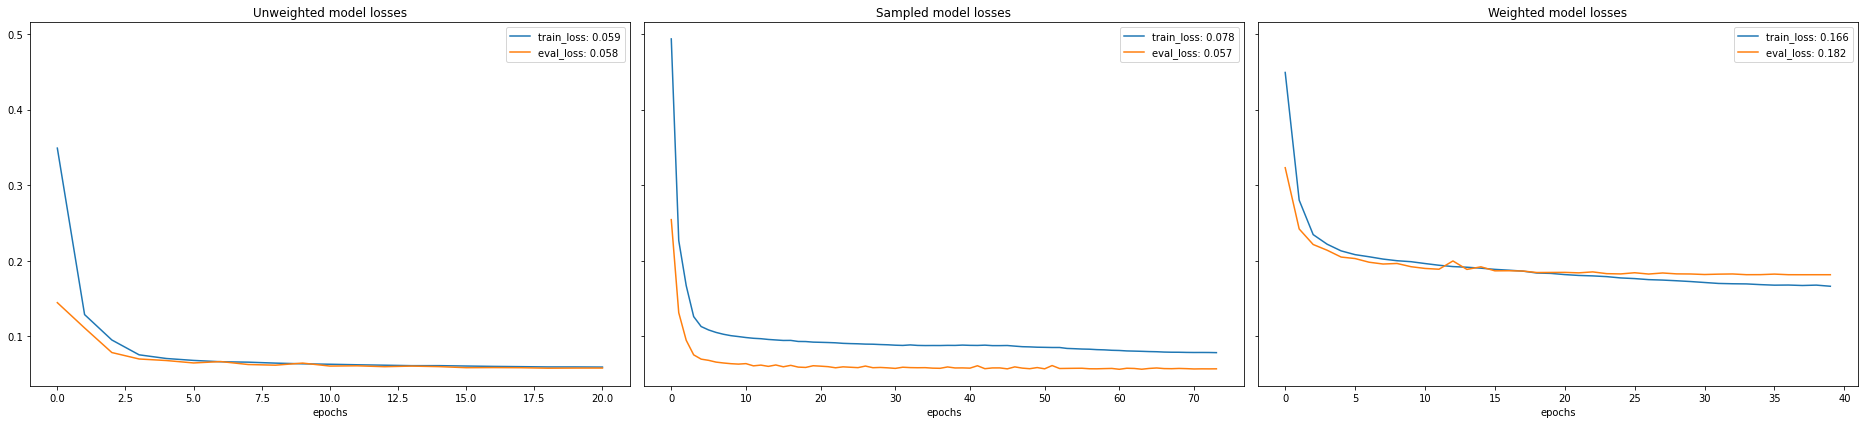

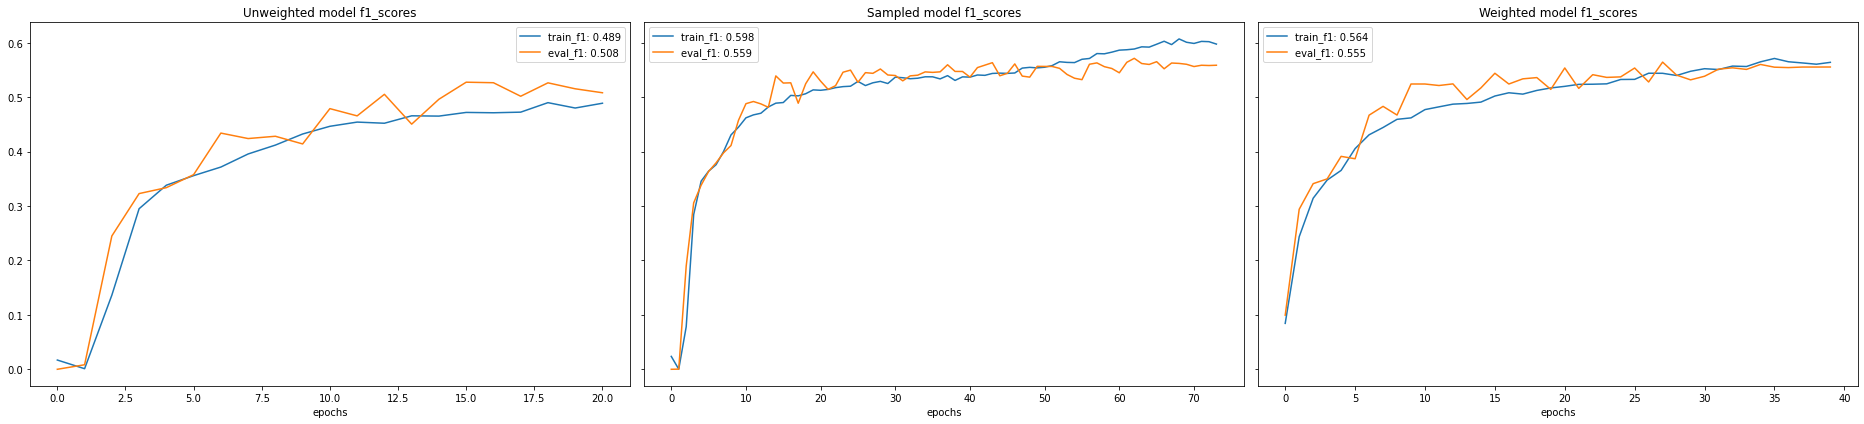

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=[26, 6], sharey=True)
ax = ax.flatten()

for i, t in enumerate(titles):
    train_metric = train_metrics[i]["train_loss"]
    eval_metric = eval_metrics[i]["eval_loss"]
    ax[i].plot(
        range(len(train_metric)),
        train_metric,
        label=f"train_loss: {train_metric[-1]:.3f}",
    )
    ax[i].plot(
        range(len(eval_metric)), eval_metric, label=f"eval_loss: {eval_metric[-1]:.3f}"
    )
    ax[i].set_title(f"{t} model losses")
    ax[i].set_xlabel("epochs")
    ax[i].legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=[26, 6], sharey=True)
ax = ax.flatten()

for i, t in enumerate(titles):
    train_metric = train_metrics[i]["train_f1"]
    eval_metric = eval_metrics[i]["eval_f1"]
    ax[i].plot(
        range(len(train_metric)),
        train_metric,
        label=f"train_f1: {train_metric[-1]:.3f}",
    )
    ax[i].plot(
        range(len(eval_metric)), eval_metric, label=f"eval_f1: {eval_metric[-1]:.3f}"
    )
    ax[i].set_title(f"{t} model f1_scores")
    ax[i].set_xlabel("epochs")
    ax[i].legend()
plt.tight_layout()
plt.show()

The sampled model seems the best, the eval losses are lower because the distributions of train and eval a different.

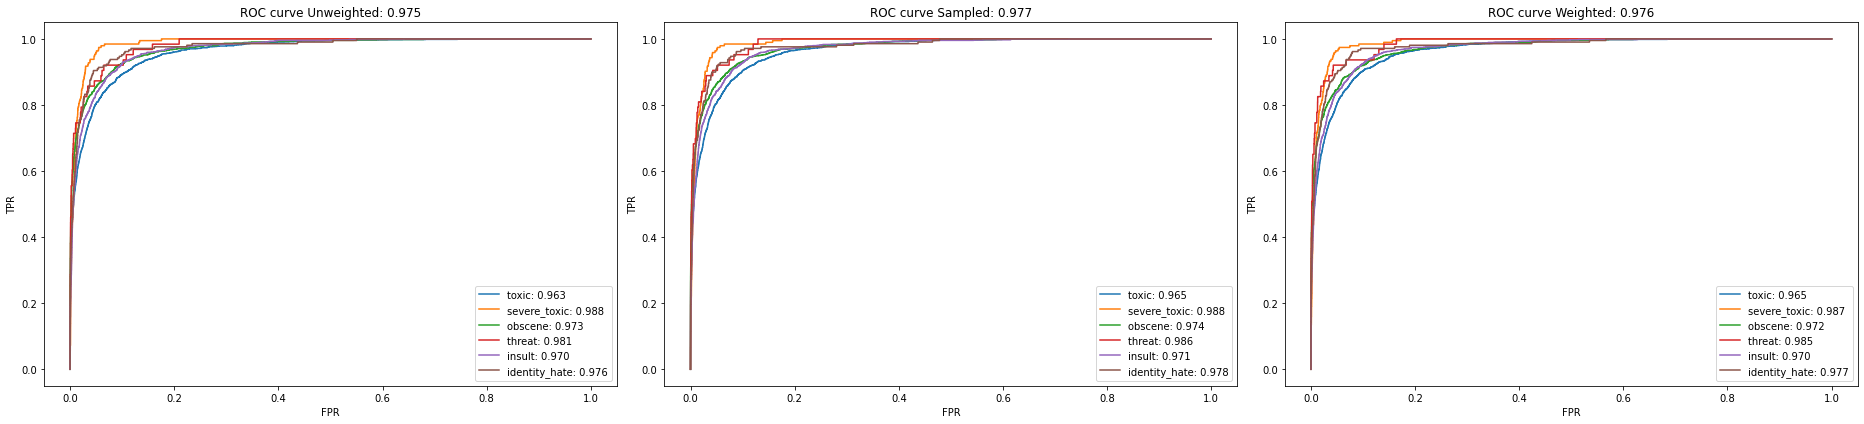

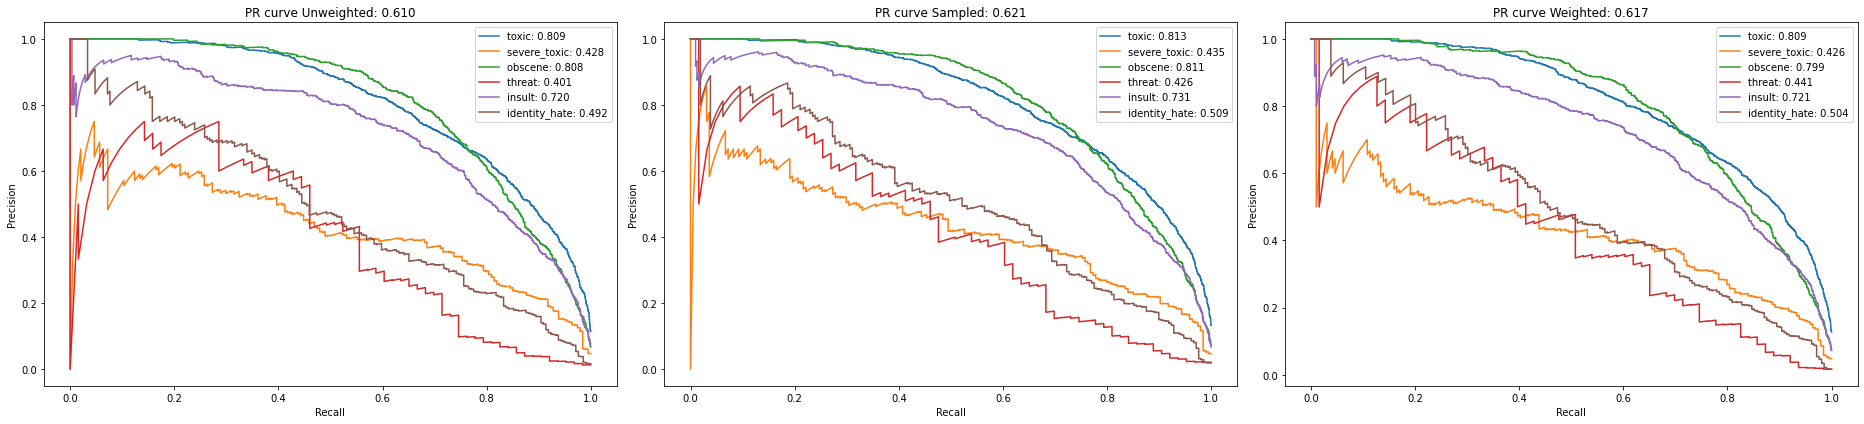

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=[26, 6])
ax = ax.flatten()

for i, t in enumerate(titles):
    for label_id, label in enumerate(labels):
        logits = predictions[i]["logits"]
        score = auroc(logits[:, label_id], y[:, label_id])
        fpr, tpr, thresh = roc(logits[:, label_id], y[:, label_id])
        ax[i].plot(fpr, tpr, label=f"{label}: {score:.3f}")
    avg_score = auroc(logits, y, average="macro", num_classes=6)
    ax[i].set_title(f"ROC curve {t}: {avg_score:.3f}")
    ax[i].set_xlabel("FPR")
    ax[i].set_ylabel("TPR")
    ax[i].legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=[26, 6])
ax = ax.flatten()

for i, t in enumerate(titles):
    for label_id, label in enumerate(labels):
        logits = predictions[i]["logits"]
        score = average_precision(logits[:, label_id], y[:, label_id])
        precision, recall, thresh = precision_recall_curve(
            logits[:, label_id], y[:, label_id]
        )
        ax[i].plot(recall, precision, label=f"{label}: {score:.3f}")
    avg_score = average_precision(logits, y, average="macro", num_classes=6)
    ax[i].set_title(f"PR curve {t}: {avg_score:.3f}")
    ax[i].set_xlabel("Recall")
    ax[i].set_ylabel("Precision")
    ax[i].legend()
plt.tight_layout()
plt.show()

Again the sampled model performed best. The ROC curves seem to overestimate the model performance because they don't take into account precision, even if the model predicts thousands of false positives (only 2k true positives in test set) the FPR will still be good, because of the data imbalance. That is why I also included PR curves. Overall the performance looking at roc and pr scores is similar to the logistic regression baseline.

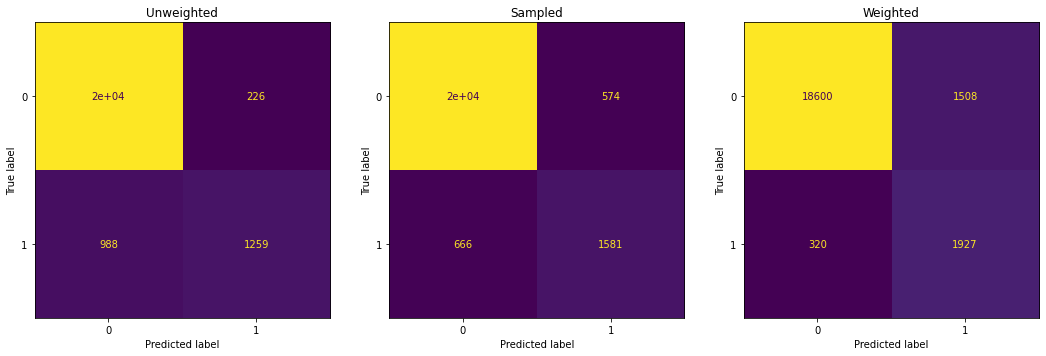

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=[18, 6])
ax = ax.flatten()

for i, model in enumerate(predictions):
    ConfusionMatrixDisplay.from_predictions(
        model["bin_y"], model["bin_preds"], ax=ax[i], colorbar=False
    )
    ax[i].set_title(titles[i])
plt.show()

The weighted model had the highest recall, but precision has suffered.

In [ ]:
for i, rep in enumerate(reports):
    print(f"{titles[i].upper():=^60}")
    print()
    print(rep[0])
    print()
    print(rep[1])
    print()

=========================UNWEIGHTED=========================

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     20108
           1       0.85      0.56      0.67      2247

    accuracy                           0.95     22355
   macro avg       0.90      0.77      0.82     22355
weighted avg       0.94      0.95      0.94     22355


               precision    recall  f1-score   support

        toxic       0.83      0.58      0.68      2134
 severe_toxic       0.59      0.17      0.26       194
      obscene       0.88      0.57      0.69      1193
       threat       0.70      0.22      0.34        63
       insult       0.81      0.48      0.61      1133
identity_hate       0.74      0.23      0.35       209

    micro avg       0.83      0.52      0.64      4926
    macro avg       0.76      0.38      0.49      4926
 weighted avg       0.82      0.52      0.63      4926
  samples avg       0.05      0.04      0.05      4926


=

f1-scores also best for sampled model.

# Fine tuning the sampled model


In [ ]:
FINE_LR = 1e-5
DECAY = 0.9


class CommentClassifierFineTune(CommentClassifier):
    def __init__(self, decay, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.decay = decay

    def configure_optimizers(self):
        optim_params = []
        decayed_lr = self.lr
        cls_params = list(
            filter(lambda kv: "classifier" in kv[0], self.model.named_parameters())
        )
        # get only parameters from (name, parameters) tuples in the cls_params
        for param in self.model.distilbert.parameters():
            param.requires_grad = False
        optim_params.append(
            {"params": [param[1] for param in cls_params], "lr": self.lr}
        )
        for idx in range(
            5, -1, -1
        ):  # loop through 6 tranformer blocks of distilbert in reverse
            params = list(self.model.distilbert.transformer.layer[idx].parameters())
            for param in params:
                param.requires_grad = True
            optim_params.append({f"params": params, "lr": decayed_lr})
            decayed_lr *= self.decay
        optimizer = torch.optim.AdamW(optim_params)
        return optimizer

For fine tuning I will train the classifier head and the 6 tranformer blocks of distilBert. Will be using learning rate decay of 0.9 for each tranformer block going backwards and changing adam for adamW as this setup overfits very quickly.

In [ ]:
BATCH_SIZE = 200  # lower batch to fit on GPU memory

train_loader = DataLoader(
    sampled_train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
)
eval_loader = DataLoader(
    eval_set, batch_size=BATCH_SIZE, pin_memory=True, num_workers=4
)

In [ ]:
comment_classifier_FT = CommentClassifierFineTune.load_from_checkpoint(
    "/content/drive/MyDrive/comments/sampled2-epoch=34-eval_f1_score=0.56.ckpt",
    decay=DECAY,
    model=bert,
    lr=FINE_LR,
    pos_weight=torch.ones(6).cuda(),
)

EPOCHS = 10

checkpoint_callback = ModelCheckpoint(
    save_top_k=10,
    monitor="eval_f1_score",
    mode="max",
    save_weights_only=True,
    dirpath="/content/drive/MyDrive/comments",
    filename="no-weights-FT-{epoch:02d}-{eval_f1_score:.2f}",
)
logger = pl.loggers.csv_logs.CSVLogger("/content/drive/MyDrive/comments")
trainer_ft = pl.Trainer(
    default_root_dir="/content/drive/MyDrive/comments",
    max_epochs=EPOCHS,
    logger=logger,
    log_every_n_steps=50,
    accelerator="gpu",
    devices=-1,
    callbacks=[checkpoint_callback],
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
# trainer_ft.fit(model=comment_classifier_FT, train_dataloaders=train_loader, val_dataloaders=eval_loader)

# Fine tuned performance

In [ ]:
comment_classifier_FT = CommentClassifierFineTune.load_from_checkpoint(
    "/content/drive/MyDrive/comments/no-weights-FT-epoch=03-eval_f1_score=0.65.ckpt",
    decay=DECAY,
    model=bert,
    lr=FINE_LR,
    pos_weight=torch.ones(6).cuda(),
)

In [ ]:
preds = trainer_ft.predict(comment_classifier_FT, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [ ]:
y, preds, logits = list(zip(*preds))
y = torch.concat(y)
preds = torch.concat(preds)
logits = torch.concat(logits)
bin_preds = (preds).any(axis=1).int()
bin_y = y.any(axis=1).int()

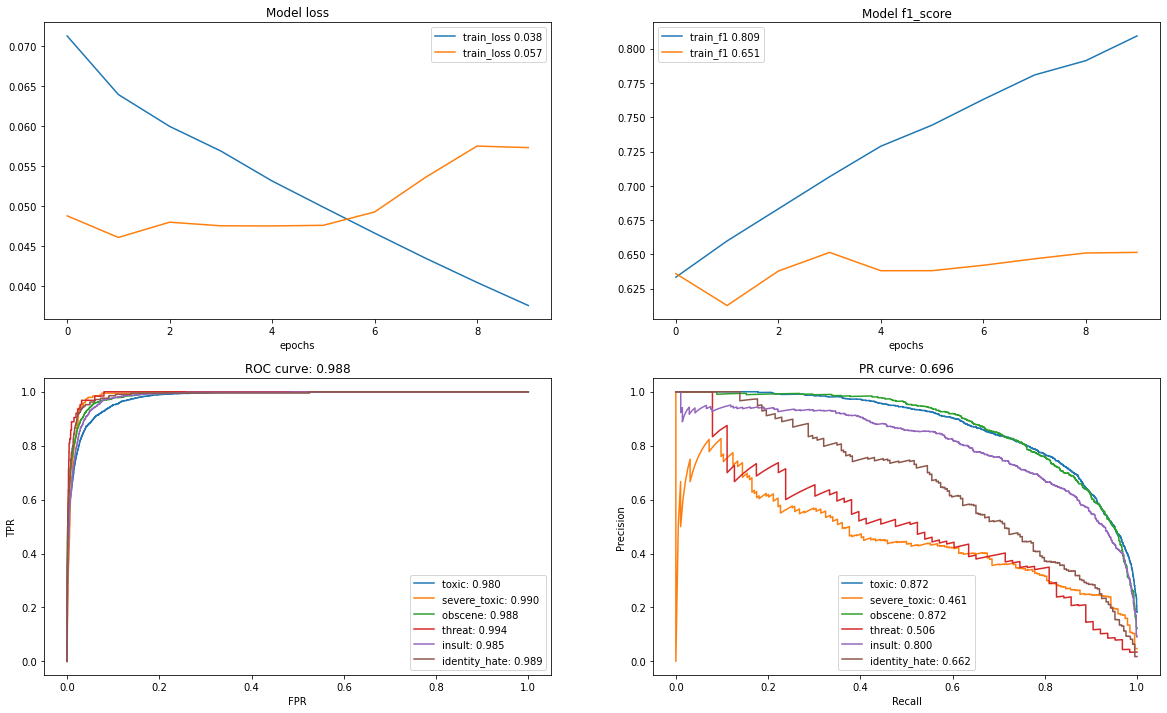

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=[20, 12])
ax = ax.flatten()

metric = pd.read_csv(
    "/content/drive/MyDrive/comments/lightning_logs/version_12/metrics.csv"
)
train_metric = metric[["train_f1_score", "train_loss_epoch"]]
eval_metric = metric[["eval_f1_score", "eval_loss"]]
train_loss = train_metric.dropna().train_loss_epoch.to_list()
eval_loss = eval_metric.dropna().eval_loss.to_list()
train_f1 = train_metric.dropna().train_f1_score.to_list()
eval_f1 = eval_metric.dropna().eval_f1_score.to_list()

ax[0].plot(range(len(train_loss)), train_loss, label=f"train_loss {train_loss[-1]:.3f}")
ax[0].plot(range(len(eval_loss)), eval_loss, label=f"train_loss {eval_loss[-1]:.3f}")
ax[0].set_title("Model loss")
ax[0].set_xlabel("epochs")
ax[0].legend()

ax[1].plot(range(len(train_f1)), train_f1, label=f"train_f1 {train_f1[-1]:.3f}")
ax[1].plot(range(len(eval_f1)), eval_f1, label=f"train_f1 {eval_f1[-1]:.3f}")
ax[1].set_title("Model f1_score")
ax[1].set_xlabel("epochs")
ax[1].legend()

for i, label in enumerate(labels):
    score = auroc(logits[:, i], y[:, i])
    fpr, tpr, thresh = roc(logits[:, i], y[:, i])
    ax[2].plot(fpr, tpr, label=f"{label}: {score:.3f}")
    ax[2].set_xlabel("FPR")
    ax[2].set_ylabel("TPR")
    ax[2].legend()
avg_score = auroc(logits, y, average="macro", num_classes=6)
ax[2].set_title(f"ROC curve: {avg_score:.3f}")

for i, label in enumerate(labels):
    score = average_precision(logits[:, i], y[:, i])
    precision, recall, thresh = precision_recall_curve(logits[:, i], y[:, i])
    ax[3].plot(recall, precision, label=f"{label}: {score:.3f}")
    ax[3].set_xlabel("Recall")
    ax[3].set_ylabel("Precision")
    ax[3].legend()
avg_score = average_precision(logits, y, average="macro", num_classes=6)
ax[3].set_title(f"PR curve: {avg_score:.3f}")

plt.show()

Looking at the f1-scores we can see the model started to overfit very quickly, the ROC and PR curves improved nicely. Predictions will be done with model from the third epoch.

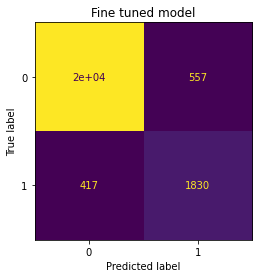

In [ ]:
ConfusionMatrixDisplay.from_predictions(bin_y, bin_preds, colorbar=False)
plt.title("Fine tuned model")
plt.show()

In [ ]:
print(classification_report(bin_y, bin_preds))
print(classification_report(y, preds, target_names=labels))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     20108
           1       0.77      0.81      0.79      2247

    accuracy                           0.96     22355
   macro avg       0.87      0.89      0.88     22355
weighted avg       0.96      0.96      0.96     22355

               precision    recall  f1-score   support

        toxic       0.74      0.83      0.78      2134
 severe_toxic       0.53      0.34      0.42       194
      obscene       0.77      0.78      0.78      1193
       threat       0.53      0.48      0.50        63
       insult       0.71      0.75      0.73      1133
identity_hate       0.66      0.57      0.62       209

    micro avg       0.73      0.76      0.75      4926
    macro avg       0.66      0.63      0.64      4926
 weighted avg       0.73      0.76      0.74      4926
  samples avg       0.07      0.07      0.07      4926



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Other metrics also improved nicely, ant the model gives a good f1-score, compared to other models.

# Checking the decision boundary

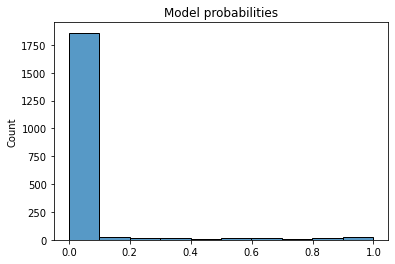

In [ ]:
sns.histplot(np.random.choice(torch.sigmoid(logits).ravel(), 2000), bins=10)
plt.title("Model probabilities")
plt.show()

Most probabilities are very close to zero.

In [ ]:
from torchmetrics.functional import recall, precision

thresholds = np.arange(0, 1, 0.01)
f1_scores = []
recall_ = []
precision_ = []
specificity_ = []
accuracy_ = []

for thresh in thresholds:
    f1_scores.append(
        f1_score(
            torch.sigmoid(logits), y, threshold=thresh, average="macro", num_classes=6
        )
    )
    recall_.append(
        recall(
            torch.sigmoid(logits), y, threshold=thresh, average="macro", num_classes=6
        )
    )
    precision_.append(
        precision(
            torch.sigmoid(logits), y, threshold=thresh, average="macro", num_classes=6
        )
    )
    specificity_.append(
        specificity(
            torch.sigmoid(logits), y, threshold=thresh, average="macro", num_classes=6
        )
    )
    accuracy_.append(
        accuracy(
            torch.sigmoid(logits), y, threshold=thresh, average="macro", num_classes=6
        )
    )

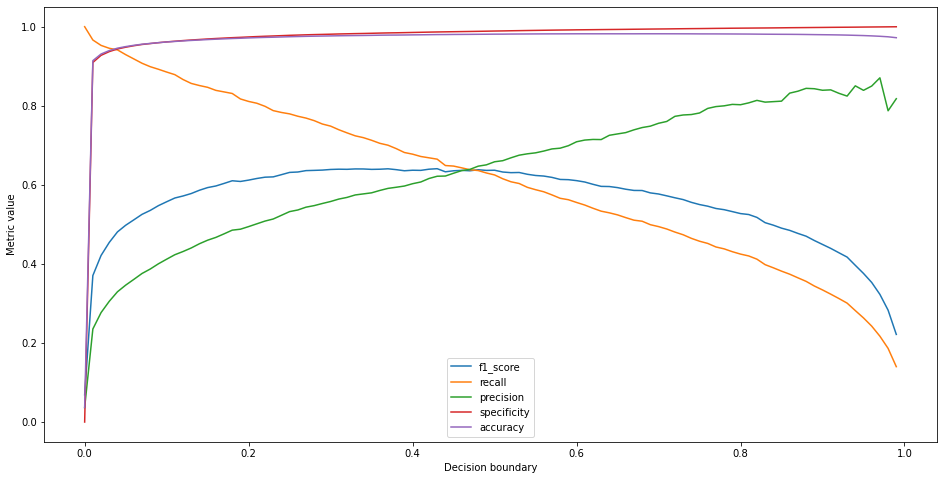

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(thresholds, f1_scores, label="f1_score")
plt.plot(thresholds, recall_, label="recall")
plt.plot(thresholds, precision_, label="precision")
plt.plot(thresholds, specificity_, label="specificity")
plt.plot(thresholds, accuracy_, label="accuracy")
plt.xlabel("Decision boundary")
plt.ylabel("Metric value")
plt.legend()
plt.show()

Seems like if we want a good recall we would be sacrificing precision for the positive class, but it is most likely better to get more false positives than to leave a lot of toxic comments.

In [ ]:
thresh_preds = (torch.sigmoid(logits) > thresholds[10]).int()
bin_thresh_preds = (thresh_preds).any(axis=1).int()
bin_y = y.any(axis=1).int()

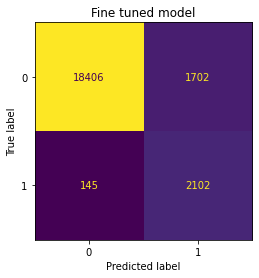

In [ ]:
ConfusionMatrixDisplay.from_predictions(bin_y, bin_thresh_preds, colorbar=False)
plt.title("Fine tuned model")
plt.show()

In [ ]:
print(classification_report(bin_y, bin_thresh_preds))
print(classification_report(y, thresh_preds, target_names=labels))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     20108
           1       0.55      0.94      0.69      2247

    accuracy                           0.92     22355
   macro avg       0.77      0.93      0.82     22355
weighted avg       0.95      0.92      0.93     22355

               precision    recall  f1-score   support

        toxic       0.53      0.94      0.68      2134
 severe_toxic       0.27      0.86      0.41       194
      obscene       0.53      0.94      0.68      1193
       threat       0.31      0.81      0.45        63
       insult       0.47      0.94      0.63      1133
identity_hate       0.36      0.83      0.51       209

    micro avg       0.49      0.93      0.64      4926
    macro avg       0.41      0.89      0.56      4926
 weighted avg       0.50      0.93      0.64      4926
  samples avg       0.07      0.09      0.07      4926



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 # Conclusions: 
 The down sampled model performed best, but it doesn't seem to be enough to be actually used in production.  


Improvements:
 * The down sampled model performed best, but should still implement per sample weights.
 * Try data augmentation with typos, synonims etc.
 * More result analysis, check the misclasiffied text, sometimes it might be hard to tell if the comment is truly toxic.
 * Try out more models, maybe use a cased one, toxic comments seem to be all caps in some cases.

# TODO:

* <s>Add a simple baseline with logistic regression or smth.</s>
* Add result analysis (lime, shap), and look at missclassified examples.